# CSE 574 Assignment 2

**Name:** Harin Rishabh\
**UBIT Name:** harinris\
**UB Person Number:** 50540017


In [281]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, recall_score, precision_score, confusion_matrix

# Data Loading:

In [282]:
from sklearn.datasets import load_iris
iris = load_iris()

In [283]:
# Creating Pandas dataframe from array data
df = pd.DataFrame(data=iris.data, columns=iris.feature_names)
df['target'] = iris.target

In [284]:
# Printing first five rows of the DataFrame
df.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target
0,5.1,3.5,1.4,0.2,0
1,4.9,3.0,1.4,0.2,0
2,4.7,3.2,1.3,0.2,0
3,4.6,3.1,1.5,0.2,0
4,5.0,3.6,1.4,0.2,0


# Data Pre-processing:

In [285]:
# printing summary of statistics
print("\nStatistics Summary:")
print(df.describe())

# Checking for Missing values
print("\nMissing Values:")
print(df.isnull().sum())


Statistics Summary:
       sepal length (cm)  sepal width (cm)  petal length (cm)  \
count         150.000000        150.000000         150.000000   
mean            5.843333          3.057333           3.758000   
std             0.828066          0.435866           1.765298   
min             4.300000          2.000000           1.000000   
25%             5.100000          2.800000           1.600000   
50%             5.800000          3.000000           4.350000   
75%             6.400000          3.300000           5.100000   
max             7.900000          4.400000           6.900000   

       petal width (cm)      target  
count        150.000000  150.000000  
mean           1.199333    1.000000  
std            0.762238    0.819232  
min            0.100000    0.000000  
25%            0.300000    0.000000  
50%            1.300000    1.000000  
75%            1.800000    2.000000  
max            2.500000    2.000000  

Missing Values:
sepal length (cm)    0
sepal width

There are no missing values in the data.

In [286]:
# Checking distribution of classes
counts = df['target'].value_counts()
print(counts)

0    50
1    50
2    50
Name: target, dtype: int64


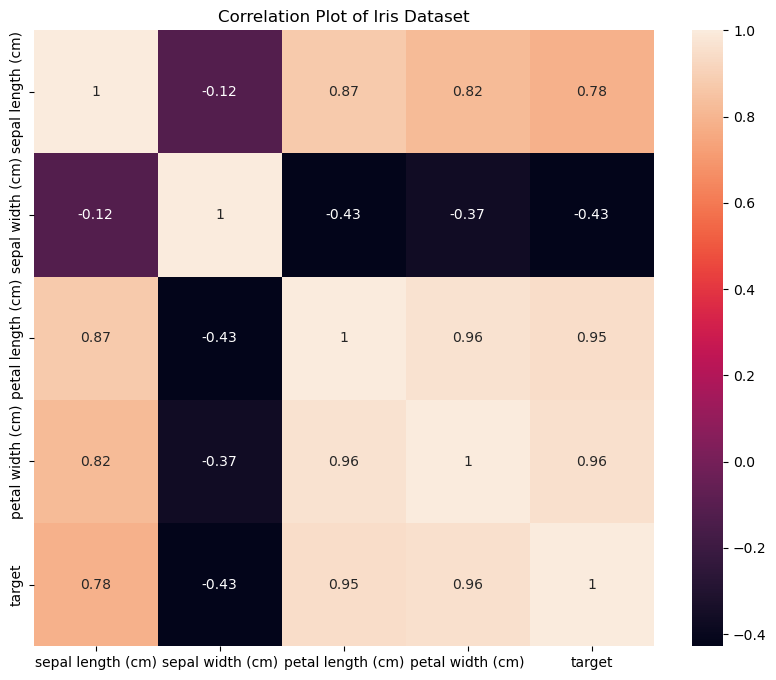

In [287]:
# Correlation plot to see the relation between features
plt.figure(figsize=(10, 8))
sns.heatmap(data=df.corr(), annot=True)
plt.title('Correlation Plot of Iris Dataset')
plt.show()

The petal length and petal width are highly correlated. Petal width and sepal length also have a good correlation.

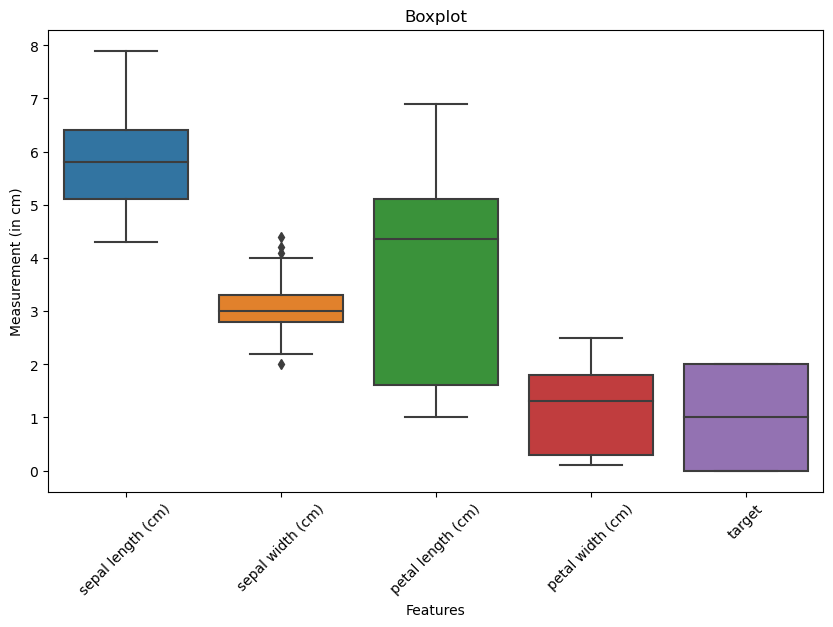

In [288]:
# Boxplot of the data
plt.figure(figsize=(10, 6))
sns.boxplot(data=df)
plt.title('Boxplot')
plt.xlabel('Features')
plt.ylabel('Measurement (in cm)')
plt.xticks(rotation=45)
plt.show()

In [289]:
# Identifying outliers using IQR
Q1 = df.quantile(0.25)
Q3 = df.quantile(0.75)
IQR = Q3 - Q1
outliers = ((df < (Q1 - 1.5 * IQR)) | (df > (Q3 + 1.5 * IQR))).any(axis=1)
print("Number of outliers: ", outliers.sum())


Number of outliers:  4


### Removing outliers

In [290]:
# Removing outliers
df = df[~outliers]

x = df.drop(columns=['target'])

y = df['target']

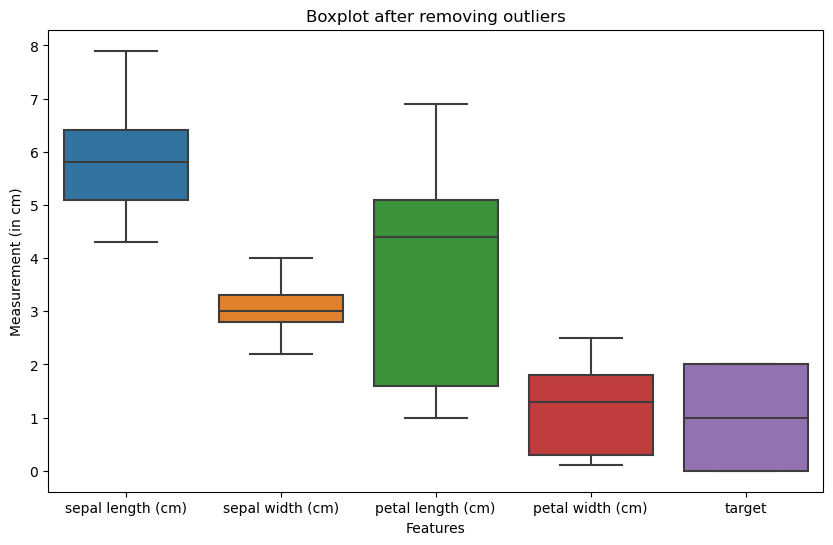

In [291]:
# Boxplot after removing outliers
plt.figure(figsize=(10, 6))
sns.boxplot(data=df)
plt.title('Boxplot after removing outliers')
plt.xlabel('Features')
plt.ylabel('Measurement (in cm)')
plt.show()

# Implementing a decision tree from scratch:

In [292]:

class TreeNode:
    """
    Define TreeNode class to represent individual nodes in the decision tree
    """
    def __init__(self, feature_index=None, threshold=None, left=None, right=None, value=None):
        # Initialize node attributes
        self.feature_index = feature_index  # Index of the feature used for splitting at this node
        self.threshold = threshold  # Threshold value for the feature used for splitting at this node
        self.left = left  # Left child node
        self.right = right  # Right child node
        self.value = value  # Majority class(of the target) in the leaf node


class DecisionTree:
    """
    Define DecisionTree class for the overall decision tree structure
    """
    def __init__(self, max_depth=None, min_samples_split=2):
        # Initialize decision tree attributes
        self.max_depth = max_depth  # Maximum depth for the tree
        self.min_samples_split = min_samples_split  # Minimum number of samples required to split a node
        self.root = None  # Root node of the decision tree

    def fit(self, X, y):
        # Fit the decision tree to the training data
        self.root = self._grow_tree(X, y, depth=0)

    def _grow_tree(self, X, y, depth):
        # Recursively grow the decision tree
        if depth >= self.max_depth or len(X) < self.min_samples_split or len(np.unique(y)) == 1:
            # Conditions for stopping tree building recursion
            unique_classes, class_counts = np.unique(y, return_counts=True)
            return TreeNode(value=unique_classes[np.argmax(class_counts)])

        # Find the best split based on entropy/information gain
        best_split = self._find_best_split(X, y)

        if best_split['info_gain'] == 0:
            # If the best split does not improve information gain further, create a leaf node
            unique_classes, class_counts = np.unique(y, return_counts=True)
            return TreeNode(value=unique_classes[np.argmax(class_counts)])

        feature_index = best_split['feature_index']
        threshold = best_split['threshold']

        # Split the data based on the best split
        indices_left = X[:, feature_index] <= threshold
        X_left, y_left = X[indices_left], y[indices_left]
        X_right, y_right = X[~indices_left], y[~indices_left]

        # Recursively grow left and right subtrees
        left = self._grow_tree(X_left, y_left, depth + 1)
        right = self._grow_tree(X_right, y_right, depth + 1)

        # Create a node with the best split information and subtrees
        return TreeNode(feature_index=feature_index, threshold=threshold, left=left, right=right)

    def _find_best_split(self, X, y):
        # Find the best split based on information gain
        best_split = {'feature_index': None, 'threshold': None, 'info_gain': -np.inf}
        _, n_features = X.shape

        for feature_index in range(n_features):
            unique_values = np.unique(X[:, feature_index])

            for threshold in unique_values:
                indices_left = X[:, feature_index] <= threshold
                y_left = y[indices_left]
                y_right = y[~indices_left]

                info_gain = self._information_gain(y, y_left, y_right)

                if info_gain > best_split['info_gain']:
                    best_split = {'feature_index': feature_index, 'threshold': threshold, 'info_gain': info_gain}

        return best_split

    def _information_gain(self, y, y_left, y_right):
        # Calculate information gain
        p = len(y_left) / len(y)
        entropy_left = self._entropy(y_left)
        entropy_right = self._entropy(y_right)
        return self._entropy(y) - (p * entropy_left + (1 - p) * entropy_right)

    def _entropy(self, y):
        # Calculate entropy
        _, counts = np.unique(y, return_counts=True)
        probabilities = counts / len(y)
        return -np.sum(probabilities * np.log2(probabilities))

    def predict(self, X):
        # Make predictions for the input data
        return np.array([self._predict_recursive(x, self.root) for x in X])

    def _predict_recursive(self, x, node):
        # Recursively predict the target values for the input data
        if node.value is not None:
            return node.value

        if x[node.feature_index] <= node.threshold:
            return self._predict_recursive(x, node.left)
        else:
            return self._predict_recursive(x, node.right)
        
    def print_tree(self, node, depth=0, indent="  "):
        # Recursively print nodes of the tree along with threshold and predicted class
        if node is None:
            return

        if node.value is not None:
            print(indent * depth + "Leaf Node: Predicted Class =", node.value)
            return

        print(indent * depth + "Feature Index:", node.feature_index)
        print(indent * depth + "Threshold:", node.threshold)

        print(indent * depth + "--> Left:")
        self.print_tree(node.left, depth + 1, indent)

        print(indent * depth + "--> Right:")
        self.print_tree(node.right, depth + 1, indent)

### Fitting the model:

In [293]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42) # Splitting data into test and train

# Standardizing features
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

# Initilizing and fitting model
model = DecisionTree(max_depth=3)
model.fit(x_train, y_train)

### Predicting from trained model:

In [294]:
y_pred = model.predict(x_test)

### Printing the tree:
One of the main advantages of Decision trees is the ease of understanding and reading it in human-readable format.

In [295]:
print("Decision Tree Structure:")
model.print_tree(model.root)

Decision Tree Structure:
Feature Index: 2
Threshold: -1.1487084621094072
--> Left:
  Leaf Node: Predicted Class = 0
--> Right:
  Feature Index: 3
  Threshold: 0.6474758391281136
  --> Left:
    Feature Index: 2
    Threshold: 0.653880201508431
    --> Left:
      Leaf Node: Predicted Class = 1
    --> Right:
      Leaf Node: Predicted Class = 2
  --> Right:
    Leaf Node: Predicted Class = 2


# Model Metrics:

Accuracy of cleaned data: 95
Recall for each class: [1.         0.90909091 0.9375    ]
Precision for each class: [1.         0.90909091 0.9375    ]
Misclassification Rate: 0.045454545454545456


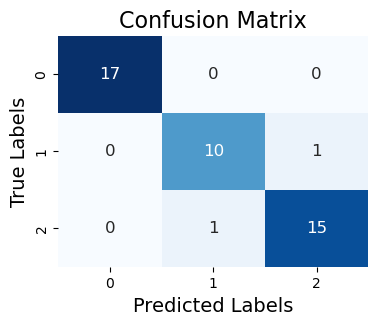

In [296]:
accuracy = accuracy_score(y_test, y_pred)   # Calculating accuracy
print("Accuracy of cleaned data:", round(accuracy*100))

recall = recall_score(y_test, y_pred, average=None) # Calculating recall score
precision = precision_score(y_test, y_pred, average=None)   # Calculating precision

print("Recall for each class:", recall)
print("Precision for each class:", precision)


cm = confusion_matrix(y_test, y_pred)

misclassification_rate = (cm.sum() - np.diag(cm).sum()) / cm.sum()  # Calculating misclassification rate

print("Misclassification Rate:", misclassification_rate)

plt.figure(figsize=(4, 3))
sns.heatmap(cm, annot=True, cmap="Blues", fmt="d", annot_kws={"size": 12}, cbar=False)
plt.xlabel('Predicted Labels', fontsize=14)
plt.ylabel('True Labels', fontsize=14)
plt.title('Confusion Matrix', fontsize=16)
plt.show()


# Final Thoughts:

1. During EDA I noticed that the data was arranged in ascending order of the target variable. This was bad for training. So I decided to go for a randomized split that ensures I have enough data from each class.
2. The data was also extremely clean, with very few outliers in sepal_width feature. I removed them using IQR technique.
2. I decided to go with entropy as the metric to find best split as I found it easier to understand through a StatQuest Video from Youtube.
3. The data required no scaling and gave same accuracy even after scaling.
4. Printing the decision tree helped me visualize and understand what I built.
5. The model is pretty accurate with an accuracy of 95%. However, we see varied results on runs, this can be fixed by implementing cross-validation techniques.